# Semantic Similarity between Two Sentence Pairs using Universal Sentence Encoder

## Introduction 

This jupyter notebook is about finding semantic similarity between two sentences using Universal Sentence Encoder. Sentence Encoders convert a piece of string into a 512-vector present in a 512-dimension latent space. A pair of sentence are converted into their vector representations. It is known that in latent space, if two sentences are similar in semantic-terms, their vectors in latent space must be closer. This closeness (or similarity) can be found using the cosine similarity (or cosine distances). 

## Future Works

- A smart score-based amalgation of word embeddings such as Word2Vec or Glo2Vec and Universal Sentence Encoder (USE) to find semantic similarity.
- A successful run of using Multi-lingual USE to try Arabic-English pair of sentences for semantic similarity.

## Shortcomings

To find the performance of vector-based lingual models for semantic similarity, Pearson Correlation Coefficient (r) is used. This coefficient is found between the vector of all sentence pairs' known and predicted similarity score (i.e. cosine similarity score). However, this can be argued that N-random selection of sentence pair from the dataset can significantly affects the value of Pearson's Correlation Coefficient. Hence a better performance measure for vector-based lingual models should be to find the errors, such as Mean Absolute Erros (MAE), Root-Mean Square Errors (RMSE), Mean Percentange Error (MPE) etc, between known and predicted similarities on benchmark dataset for semantic similarity. 


In [1]:
# Imports 
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # Required for USE model
from sklearn.metrics.pairwise import cosine_similarity 
from scipy.stats import pearsonr
from operator import itemgetter  # To sort the dataset according to similarity

In [2]:
# Load USE Model (locally saved in computer)
def load_model(module_url):
    return hub.Module(module_url)

In [3]:
# Cosine distance, you can use sklearn.metrics.pairwise.cosine_similarity, which is the same thing
def cos_distance(vecA, vecB):
    return (  np.dot(vecA,vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB)) )

In [4]:
# This function parse the dataset file and return a list of list. This list of list is in this format
# [[sentenceA, sentenceB, knownSimilarity], [sentenceA, sentenceB, knownSimilarity],...]
# Also the dataset file should be as follow:
# sentenceA[TAB-Key]sentenceB[TAB-key]knownSimilarity[nextLine]
# sentenceA[TAB-Key]sentenceB[TAB-key]knownSimilarity[nextLine]
# sentenceA[TAB-Key]sentenceB[TAB-key]knownSimilarity[nextLine]
# sentenceA[TAB-Key]sentenceB[TAB-key]knownSimilarity[nextLine]
# ...
def get_dataset_sentences(filepath):    
    data = open(filepath, "r").read()
    dataLines = data.split("\n")
    
    allLines = []
    for line in dataLines:
        columns = line.split('\t')
        if len(columns) == 3:
            allLines.append([columns[0],columns[1], float(columns[2])])
        
    allLines = sorted(allLines, key=itemgetter(2))
    return allLines

In [5]:
# This function basically starts the tensorflow graph, loads the model and 
# returns the 512 vector representation of each sentence. 
# Then these vectors are used to find cosine similarity
def get_similarity(embed, dataset_filepath, sentenceA="it is a cat", sentenceB="it is a dog", dataset= True):

    if dataset:
        dataLines = get_dataset_sentences(dataset_filepath)    
        with tf.Session() as session:
            session.run([tf.compat.v1.global_variables_initializer(), tf.tables_initializer()])
              
            all_sentences  = []
            all_knownSim = []
            for line in dataLines:
                columns = line
                if len(columns) == 3:
                    sentenceA, sentenceB, knownSim = columns[0], columns[1], float(columns[2])
                    
                    all_sentences.append(sentenceA)
                    all_sentences.append(sentenceB)
                    all_knownSim.append(knownSim)
             
            message_embeddings = session.run(embed(all_sentences))
            
            vectors = np.array(message_embeddings)
            print (vectors.shape)
        
            all_vectors = np.zeros((int(vectors.shape[0]/2), vectors.shape[1],2))
            count = 0
            
            for i in range(len(vectors)):
                if i%2 == 0:
                    all_vectors[count,:,0] = vectors[i,:]
                    all_vectors[count,:,1] = vectors[i+1,:]
                    count = count+1
            
            all_sim = np.zeros((len(all_knownSim), 2))
            for i in range((all_vectors.shape[0])):
                calcSim = cos_distance( all_vectors[i,:,0], all_vectors[i,:,1]) *5.0
                calcSim = round(calcSim, 1)
                all_sim[i,0] = calcSim
                all_sim[i,1] = all_knownSim[i]
#                 print ("Calculated Similarity: {:^6}\tKnown Similarity: {:^6}".format(calcSim, all_knownSim[i]))
            return all_sim, dataLines
    else:
        message = [sentenceA, sentenceB]
        with tf.Session() as session:
            session.run([tf.global_variables_initializer(), tf.tables_initializer()])
            message_embeddings = session.run(embed(message))
            vectors = np.array(message_embeddings)
            return cos_distance(vectors[0,:], vectors[1,:])

In [6]:
# This function is for plotting dataset.
# The arguments passed to it are basically in this format
# data -> Numpy array of (N,2) size where N is the number of sentence pairs (or number of rows in dataset),
# and 2 columns where first one is predictedSimilarity and second one is knownSimilarity
# dataset_filepath -> used to save the figure by appending the '_result.pdf' in the dataset filepath
def plotting_sim(data, dataset_filepath):
    
    print ("Pearson Correlation Coeff: {}\n".format(pearsonr(data[:,0], data[:,1])[0]))
    
    plt.figure(1,figsize=(12,10))
    x = np.arange( data.shape[0] )
    
    plt.subplot(3,1,1)
    plt.scatter(x, data[:,0],marker='o', c="green")
    plt.scatter(x, data[:,1],marker='x', c="black")
    plt.xlabel('Sentence Pair Number')
    plt.ylabel('Similarity Score')
    plt.ylim([0,6])
    plt.legend(['Calc. Similarity','Known Similarity'])
    plt.grid(True)

    plt.subplot(3,1,2)
    plt.plot(x, (data[:,0] - data[:,1]), 'b--')
    plt.xlabel('Similarity Pair Number')
    plt.ylabel('Error Difference')
    plt.ylim([-5,5])
    plt.legend(['Known - Predicted'])
    plt.grid(True)

    
    plt.subplot(3,1,3)
#    plt.scatter(data[:,1], data[:,0], marker='o', c='green')
    plt.plot(data[:,1], data[:,0], 'ro')
    plt.xlabel('Known Similarity')
    plt.ylabel('Calc. Similarity')
    plt.legend(['Relation'])
    plt.xlim([0,6])
    plt.ylim([0,6])
    plt.grid(True)
    plt.savefig(dataset_filepath.split(".")[0] + "_results.pdf", dpi=500, quality=95)
    plt.show()
    

In [7]:
# This function saved the results. The results are saved as follow:
# sentenceA[TAB-Key]sentenceB[TAB-Key]knownSimilarity[TAB-Key]predictedSimilarity[nextLine]
# sentenceA[TAB-Key]sentenceB[TAB-Key]knownSimilarity[TAB-Key]predictedSimilarity[nextLine]
# sentenceA[TAB-Key]sentenceB[TAB-Key]knownSimilarity[TAB-Key]predictedSimilarity[nextLine]
# sentenceA[TAB-Key]sentenceB[TAB-Key]knownSimilarity[TAB-Key]predictedSimilarity[nextLine]
# ....
def save_results(result_filepath,dataLines, all_predictions):
    
    result_file = open(result_filepath, 'w')
    count = 0
    for first, second, knownSim in dataLines:
        if float(knownSim) == all_predictions[count,1]:
            to_write = str(first) + "\t" + str(second) + "\t" + str(knownSim) + "\t" + str(all_predictions[count,0]) + "\n"
            result_file.write(to_write)
        count = count + 1
        
    result_file.close()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
(812, 512)
Pearson Correlation Coeff: 0.40067046967163006



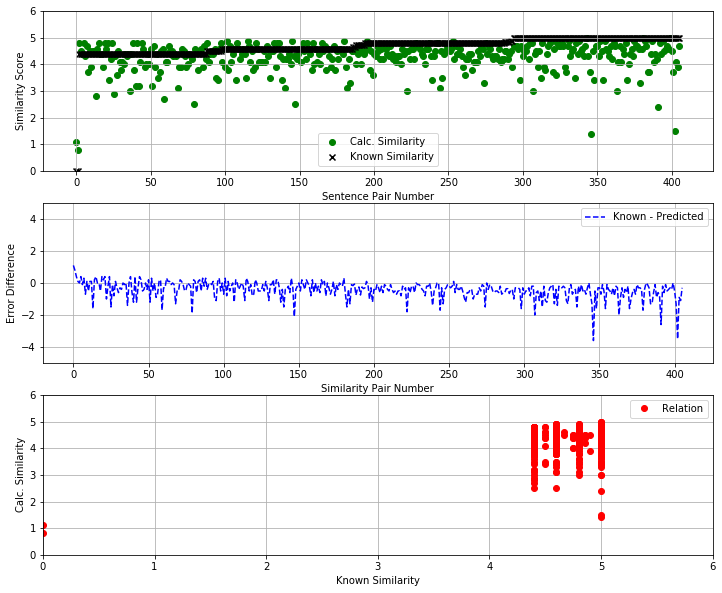

In [10]:
# This piece of code is not wrapped in a function as Jupyter remembers the 
# main variable when run like this. Hence if you want to run the model again and 
# again, you can simply load the model only once (which takes a lot of time) and then 
# comment that line and run the remaining code again and again.

module_url = r"D:\\USE_Project\\USE3"
dataset_filepath = r"D:\\USE_Project\\Codes\\translated_dataset.txt"
result_filepath = dataset_filepath.split('.')[0] + "_results.txt"

sentenceA = "she has been on the bed since five in the evening"
sentenceB = "death be not proud"

use_dataset = True
model = load_model(module_url)

if use_dataset:
    sim, dataLines = get_similarity(model, dataset_filepath, sentenceA = sentenceA, sentenceB = sentenceB, dataset = use_dataset)
    save_results(result_filepath, dataLines, sim)
    plotting_sim(sim,dataset_filepath)

else:
    sim = get_similarity(model, dataset_filepath, sentenceA = sentenceA, sentenceB = sentenceB, dataset = use_dataset)
    print ("RESULTS:\nSentence-A: {}\nSentence-B{}\nPredicted-Similarity: {}".format(sentenceA,sentenceB,str(sim)))